# ML Workshop
## Next Gen Stats | TAC Summit 2019 

The purpose of this workshop is to demonstrate some basic machine learning techniques. This workshop assumes a basic understanding of Python. The format will include code snippets interspersed with explanations on what the code is doing along with the why we're doing it.

The problem we're going to solve is __given the current situation in the game, can we predict the upcoming play?__

The way to think about this problem is that given current traditional stats (such as time left in the game, the difference in score, the current down and distance), can we effectively predict whether the play will be a pass or a rush?

To get started, let's import some packages we're going to use during this workshop.

In [1]:
import os
import sys
import json
import requests
import io

import pandas as pd
import numpy as np
import xgboost as xgb

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics

def drop_columns(df, columns_to_remove):
    if isinstance(columns_to_remove, str):
        columns_to_remove = [columns_to_remove]
    for c in columns_to_remove:
        if c in df.columns:
            df = df.drop(c, axis=1)
    return df

We're including a helper function to remove columns from our dataset. This provides a check to make sure the column exists before deleting to prevent errors. Otherwise we're just bringing some libraries we're going to use into the context.


## Import Data

The key dataset construct we're using is a Pandas DataFrame. DataFrame's have a lot of useful built-in features and functions that allow making data analysis and data prep very simple. In addition, importing tabluar data into a DataFrame is very easy.

__Important Note: the URL listed here is only going to be valid for today.__

In [2]:
if not os.path.exists('./pass_vs_rush_training.csv'):
    print("Downloading file from AWS")
    response = requests.get('https://s3.amazonaws.com/aws-ngs-ml/tac-2019/pass_vs_rush_training.csv')
    if response.status_code == 200:
        downloaded_df = pd.read_csv(io.StringIO(response.text))
        downloaded_df.to_csv('pass_vs_rush_training.csv', index=False)
    else:
        raise Exception("Could not download data")
    
df = pd.read_csv('pass_vs_rush_training.csv')
len(df)

100812

Looks like there are roughly 100,000 plays available to us - this is good since there are plenty of samples for us to gain a reasonable understanding of what tends to happen. Let's see what the data looks like:

In [3]:
df.head()

,playType,down,gameClock,quarter,scoreDifferential,yardsToGo,isQbKneel,DB_count,DL_count,K_count,LB_count,LS_count,OL_count,P_count,QB_count,RB_count,TE_count,WR_count,yardsToEndzone
0,play_type_rush,1,14:56,1,0.0,10,False,0,0,0,0,0,5,0,1,1,1,3,75
1,play_type_rush,1,14:51,1,0.0,10,False,0,0,0,0,0,5,0,1,1,1,3,72
2,play_type_rush,1,14:55,1,0.0,10,False,0,0,0,0,0,5,0,1,1,1,3,85
3,play_type_rush,1,15:00,1,0.0,10,False,0,0,0,0,0,5,0,1,1,1,3,75
4,play_type_pass,2,14:27,1,0.0,7,False,0,0,0,0,0,5,0,1,1,1,3,72


We're simply outputting the first 5 records of the dataset to help us briefly understand what data is available to us. We're going to run some more commands to help us understand the distribution of the play a little more later, but let's define some of the columns.

Here's a breakdown of the different columns:

| Column Name | Description |
| ----------- | ----------- |
| playType | The type of play that was run - this will eventually be our label |
| down | The down of the current play |
| gameClock | How much time is left on the game clock, format is min:sec |
| quarter | The quarter of the current play |
| scoreDifferential | The difference in score between the offensive team and the defensive team |
| yardsToGo | The yards left before a first down - already cleaned up for goal line situations |
| isQbKneel | Whether the current play was a QB Kneel or not |
| DB_count | The number of rostered DB's on the field for offense |
| DL_count | The number of rostered DL's on the field for offense |
| K_count | The number of rostered K's on the field for offense |
| LB_count | The number of rostered LB's on the field for offense |
| LS_count | The number of rostered LS's on the field for offense |
| OL_count | The number of rostered OL's on the field for offense |
| P_count | The number of rostered P's on the field for offense |
| QB_count | The number of rostered QB's on the field for offense |
| RB_count | The number of rostered RB's on the field for offense |
| TE_count | The number of rostered TE's on the field for offense |
| WR_count | The number of rostered WR's on the field for offense |
| yardsToEndzone | Number of yards to reach the endzone |

A few notes:
- For the personnel counts, the reason we're including defensive and special teams is to factor in plays where a non-traditional offensive position may come in for a play. Although uncommon, it can exist and is something we can handle.
- Given the initial data, there are a few steps we may want to take to cleanup some of the data to better suit our model, which we'll go over through the notebook.

## Data Cleanup & Preparation

Knowing some of the basics of our data, there are a few cleanup steps we're going to need to take to make sure our training process goes smoothly.

#### QB Kneels

Remember that one of the columns we have in our dataset is `isQbKneel` - technically QB kneels are rushing plays, but they might negatively influence our modeling since QB kneels are significantly different than traditional running plays. Let's see how many plays are QB kneels.

In [4]:
df.groupby('isQbKneel')['playType'].describe()['count']

isQbKneel
False    99587
True      1225
Name: count, dtype: object

Looks like we have roughly 1,200 plays that are QB kneels - let's remove them from the dataset since we know we don't want them.

In [5]:
df = df[~df['isQbKneel']]
df = drop_columns(df, 'isQbKneel')
len(df)

99587

We're effectively selecting all plays where `isQbKneel` is false, and assigning it back to our main DataFrame. We're also printing out the number of plays we have in our dataset which confirms we removed the QB kneels correctly.

We also remove the isQbKneel column since we don't need it anymore. 

#### Sack Plays

The next step is to look at what play types are available to us.

In [6]:
list(df['playType'].unique())

['play_type_rush', 'play_type_pass', 'play_type_sack']

We have 3 play types - play_type_rush, play_type_pass, and play_type_sack. We initially discussed talking about whether a play will be a passing play or a rushing play, so play_type_sack will need to be changed. Since sacks are intended passing plays, we can relabel all sack plays as passing plays.

In [7]:
def change_sack_to_pass(play_type):
    if play_type == 'play_type_sack':
        return 'play_type_pass'
    return play_type

df['playType'] = df['playType'].map(change_sack_to_pass)
list(df['playType'].unique())

['play_type_rush', 'play_type_pass']

We created a function called `change_sack_to_pass` that takes in the play type string. If the string matches "play_type_sack" - we return "play_type_pass", otherwise we return the original value. 

From there, we select the column and run `DataFrame[column].map` to it, which is effectively saying "for each row in this data set, run the provided function with the original value as the input". We take the output of each row for the function and store it back to the playType column in our DataFrame. To confirm we did this correctly, we list out the unique playType values again.

You can now see that there are only 2 play types - "play_type_pass" and "play_type_rush".

#### Game Clock

The current format of the game clock isn't the most intuitive for a computer to understand, since both minutes and seconds are present. However, this information is still valuable - we want to know how much time is left in the game. We can accomplish this by converting the existing format into number of seconds left. 

One caveat to consider is where in time do we want to set as 0. Do we want to know how many seconds are left in the quarter? The half? The entire game? 

The way to answer that question is to think about how gameplay differs between each time split. 

If a team has the ball with 60 seconds left in the first quarter, will that team act similarly as if they had 60 seconds in the second quarter, all other things being equal? Generally, the answer is no. The same goes for 3rd vs. 4th quarter. Given this, quarter does not make much sense. 

What about half? Does a team with 60 seconds left in the first half act similarly to having 60 seconds left in the second half (once again all other things being equal)? More often than not, the answer is yes. This is a good candidate to use as a split. Let's write this out now.

In [8]:
def translate_game_clock(row):
    raw_game_clock = row['gameClock']
    quarter = row['quarter']
    minutes, seconds = raw_game_clock.partition(':')[::2]
    total_seconds_left_in_quarter = int(seconds) + (int(minutes) * 60)

    if quarter == 3 or quarter == 1:
        return total_seconds_left_in_quarter + 900
    elif quarter == 4 or quarter == 2:
        return total_seconds_left_in_quarter

if 'gameClock' in list(df.columns):
    df['secondsLeftInHalf'] = df.apply(translate_game_clock, axis=1)
    df = drop_columns(df, 'gameClock')

df.head()

,playType,down,quarter,scoreDifferential,yardsToGo,DB_count,DL_count,K_count,LB_count,LS_count,OL_count,P_count,QB_count,RB_count,TE_count,WR_count,yardsToEndzone,secondsLeftInHalf
0,play_type_rush,1,1,0.0,10,0,0,0,0,0,5,0,1,1,1,3,75,1796
1,play_type_rush,1,1,0.0,10,0,0,0,0,0,5,0,1,1,1,3,72,1791
2,play_type_rush,1,1,0.0,10,0,0,0,0,0,5,0,1,1,1,3,85,1795
3,play_type_rush,1,1,0.0,10,0,0,0,0,0,5,0,1,1,1,3,75,1800
4,play_type_pass,2,1,0.0,7,0,0,0,0,0,5,0,1,1,1,3,72,1767


This code is a little more complex. The function we wrote takes in the full row as an input, grabs the gameClock and the quarter, parses out the minutes and seconds, converts the minutes into seconds, then adds it all together. Because we want seconds left in the half, and game clock represents time left in the quarter, we need to add the following quarter if the current quarter is 1 or 3. Once we have our final value we can return it back.

Once our function is defined, we call `DataFrame.apply` which is similar to `map`, but passes in the whole row as opposed to a single column in the row. We store the new value as a new column in our dataset, called `secondsLeftInHalf` and remove `gameClock` since we don't need it anymore.

Finally, we print a sample of our dataset again to look at the data again.

#### Quarter

Since we just transformed time to be based on the half and not the quarter, and because we discussed that play calling decisions do not change much by quarters, we need to transform the quarter column to half. Let's do that now.

In [9]:
if 'quarter' in list(df.columns):
    df['half'] = df['quarter'].map(lambda q: 2 if q > 2 else 1)
    df = drop_columns(df, 'quarter')

This syntax is a little different than before. Rather then define a function separately, we defined the function inside of the map function with a lambda. Basically, it's an anoymous function that returns 2 if the quarter is greater than 2, otherwise it returns 1. 

In [10]:
df.head()

,playType,down,scoreDifferential,yardsToGo,DB_count,DL_count,K_count,LB_count,LS_count,OL_count,P_count,QB_count,RB_count,TE_count,WR_count,yardsToEndzone,secondsLeftInHalf,half
0,play_type_rush,1,0.0,10,0,0,0,0,0,5,0,1,1,1,3,75,1796,1
1,play_type_rush,1,0.0,10,0,0,0,0,0,5,0,1,1,1,3,72,1791,1
2,play_type_rush,1,0.0,10,0,0,0,0,0,5,0,1,1,1,3,85,1795,1
3,play_type_rush,1,0.0,10,0,0,0,0,0,5,0,1,1,1,3,75,1800,1
4,play_type_pass,2,0.0,7,0,0,0,0,0,5,0,1,1,1,3,72,1767,1


Now our data is reasonably clean, let's start by analyzing and visualizing some of the data to make sense of how things are working.

## Data Analysis & Visualization

Our first analysis is going to be to describe the data to us - are there any strange max/mins/averages that we should note?


In [11]:
df.describe()

,down,scoreDifferential,yardsToGo,DB_count,DL_count,K_count,LB_count,LS_count,OL_count,P_count,QB_count,RB_count,TE_count,WR_count,yardsToEndzone,secondsLeftInHalf,half
count,99587.000000,99587.000000,99587.000000,99587.000000,99587.000000,99587.000000,99587.000000,99587.000000,99587.000000,99587.000000,99587.000000,99587.000000,99587.00000,99587.000000,99587.000000,99587.000000,99587.000000
mean,1.792784,-1.546025,8.643779,0.002179,0.004067,0.000181,0.002932,0.000954,5.039302,0.000964,1.001898,1.111219,1.26159,2.574643,52.005975,847.524135,1.500005
std,0.819757,10.602565,3.962979,0.072575,0.065355,0.013443,0.097420,0.030871,0.252240,0.031033,0.066820,0.362554,0.57708,0.720213,24.343572,543.263734,0.500003
min,1.000000,-44.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,1.000000,0.000000,1.000000
25%,1.000000,-7.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000,1.000000,1.000000,1.00000,2.000000,33.000000,350.000000,1.000000
50%,2.000000,0.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000,1.000000,1.000000,1.00000,3.000000,56.000000,843.000000,2.000000
75%,2.000000,4.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000,1.000000,1.000000,2.00000,3.000000,73.000000,1319.000000,2.000000
max,4.000000,44.000000,44.000000,4.000000,4.000000,1.000000,5.000000,1.000000,8.000000,1.000000,3.000000,4.000000,4.00000,5.000000,99.000000,1800.000000,2.000000


Down is limited between 1 and 4 which is good. The max and min score differential is 44 and -44, which makes sense - there was one game where a team was down by 44 - consequently this means another team was ahead by 44. 

One thing of interest is a play where there were 4 DB's on the offense - let's take a quick look.

In [12]:
df[df['DB_count'] == 4]

,playType,down,scoreDifferential,yardsToGo,DB_count,DL_count,K_count,LB_count,LS_count,OL_count,P_count,QB_count,RB_count,TE_count,WR_count,yardsToEndzone,secondsLeftInHalf,half
16007,play_type_rush,4,-21.0,15,4,0,0,4,1,0,1,0,1,0,0,80,1661,2
36996,play_type_rush,4,-7.0,21,4,0,0,3,1,0,1,0,1,1,0,97,1281,1
56955,play_type_rush,4,0.0,8,4,0,0,2,1,0,1,0,2,1,0,73,1752,1
68509,play_type_pass,4,-13.0,5,4,1,0,3,1,0,1,0,0,1,0,70,863,1
72759,play_type_pass,4,0.0,6,4,0,0,3,1,0,1,0,0,2,0,66,1500,1
83175,play_type_pass,4,-10.0,3,4,1,0,3,1,0,1,0,1,0,0,55,509,1
85428,play_type_rush,4,-11.0,4,4,0,0,3,1,0,1,0,1,0,1,66,519,2
94142,play_type_pass,4,-3.0,7,4,1,0,3,1,0,1,0,0,1,0,72,498,1
98049,play_type_rush,4,4.0,5,4,0,0,3,1,0,1,0,1,0,1,58,251,2


Given these plays, it seems like these are fake punt plays. Since it may be interesting to put those in the model, we can leave them for now, but this is a possible candidate to remove if training doesn't go well.

#### Append Numeric Play Type

So far we've relied on using "play_type_pass" and "play_type_rush" directly to split our data. However, this can occasionally be limiting as we don't get the flexibility of looking at regression charts. Since our training is going to involve using only numerical values, let's convert this quickly.

In [13]:
df['numericPlayType'] = df['playType'].map(lambda p: 1 if p == 'play_type_pass' else 0)

Once again, this code is effectively mapping an individual column and storing it to a new column. In this case, 1 and 0 are arbitrary and could easily be reversed. 

Another good thing to look at is correlation (r^2) values for each of the columns we have

In [14]:
df.corr()['numericPlayType']

down                 0.212911
scoreDifferential   -0.160036
yardsToGo            0.087575
DB_count            -0.012379
DL_count            -0.043065
K_count             -0.004099
LB_count            -0.014378
LS_count            -0.011556
OL_count            -0.121892
P_count             -0.011887
QB_count            -0.015698
RB_count            -0.166103
TE_count            -0.178932
WR_count             0.279380
yardsToEndzone       0.018054
secondsLeftInHalf   -0.099066
half                 0.004589
numericPlayType      1.000000
Name: numericPlayType, dtype: float64

Correlation (r^2) is a measure of how related 2 variables are. In our case, we're quantifying how related our features are to the numeric play type. The larger the number is, the higher the correlation is. For negative correlations, that simply means that it's an inverse relationship. Examples will help explain this concept further.

Down, score differential and the offensive positions have some of the larger correlation values in our dataset. The way to think about it is "as the down increases, the likelihood that the play is a pass also increases". Likewise, for score differential, as the score differential increases, the likelihood that the play is a pass _decreases_. The decrease is due to a negative correlation value.

Correlation values imply that data points are related in a linear fashion and tends to be useful in judging whether a data point is a good feature.

Now we're going to use a lot more of the different plotting libraries we've imported from before. The primary library we're going to use is [Seaborn](https://seaborn.pydata.org/index.html).

#### Play Types

How many plays are passing plays vs. rushing plays in the full data set?

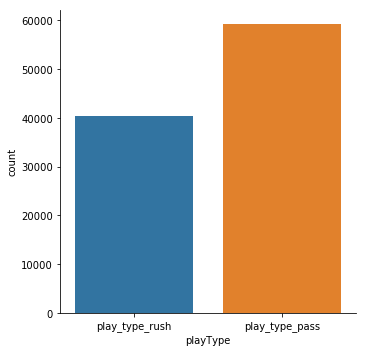

In [15]:
sns.catplot(x='playType', kind='count', data=df, orient='h')
plt.show()

Looks like there are about 20,000 more passing plays than rushing plays. This is important to think about because this means the distribution between both play types is not split 50/50. By default, we should expect slightly more passing plays than rushing plays for every split, by about 20%

#### Down

Let's look at down - do we think there's a specific down that tends to have more passes then rushes?

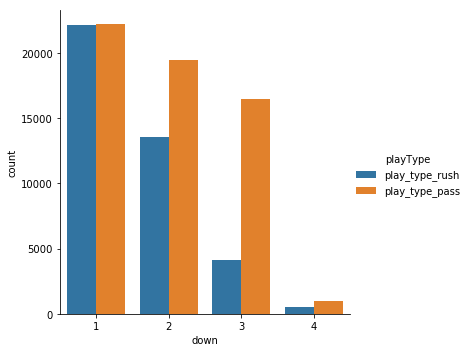

In [16]:
sns.catplot(x="down", kind="count", hue='playType', data=df);
plt.show()

Looks like 3rd down has significantly more passes than rushes. 1st down is very evenly split, 2nd down has a few more passing plays then rushing plays, but given the initial data distribution this is probably meaningless.

#### Score Differential

Reminder that score differential is calculated by (current team score - opponent score). A positive score differential means the offensive team is currently winning in the context of the play. Negative means the offensive team is currently losing.

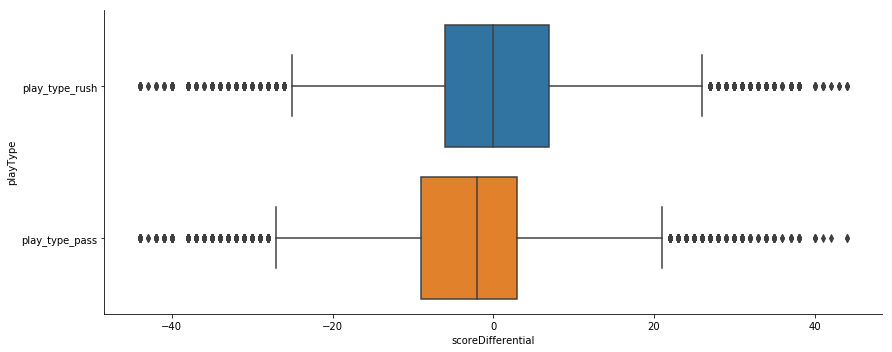

In [17]:
sns.catplot(x='scoreDifferential', y='playType', kind='box', data=df, aspect=2.5)
plt.show()

Although very slight, it looks like there are more rushing plays when the offense has a positive score differential. This means that when a team is winning, they run more rushing plays then passing plays. 

#### Yards to Go

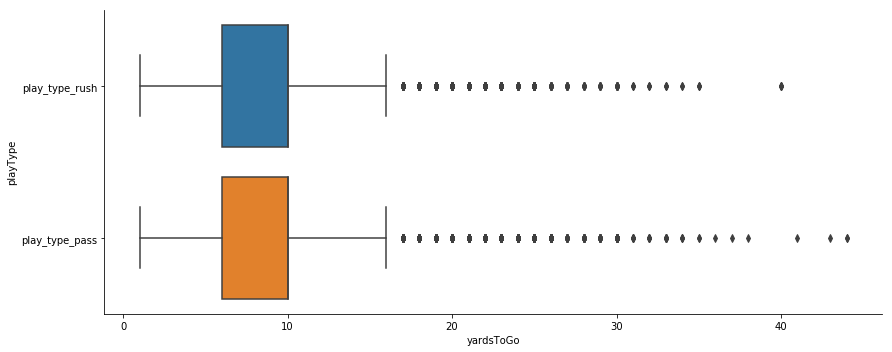

In [18]:
sns.catplot(x='yardsToGo', y='playType', kind='box', data=df, aspect=2.5)
plt.show()

This chart really doesn't show much - it looks like regardless of yards to go, passing plays and rushing plays are run evenly. This doesn't make sense per our intuition of the sport - generally speaking, you wouldn't pass when you have 1 yard to go, correct?

Let's split this plot per down:

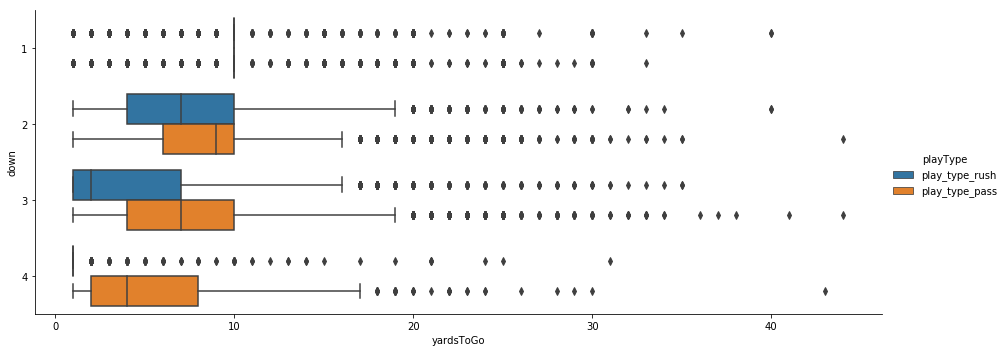

In [19]:
sns.catplot(x='yardsToGo', y='down', hue='playType', kind='box', data=df, orient='h', aspect=2.5)
plt.show()

This is a little more interesting. Clearly when factoring in down, there are some differences between passing plays and rushing plays, particularly on 3rd down - the larger yardsToGo is on 3rd down the stronger the difference is. 

This kind of plot is called "Boxen" or "Letter Value Plot". [This](https://stackoverflow.com/questions/52403381/how-boxen-plot-is-different-from-box-plot) post explains more of the value of this plot, but it is effectively a distribution plot for the data points.

#### Regression Plots

With our numericPlayType column we created earlier, we can use that to our advantage to build a quick regression plot for our data. This will help guide us on whether there are trends within the data as well.

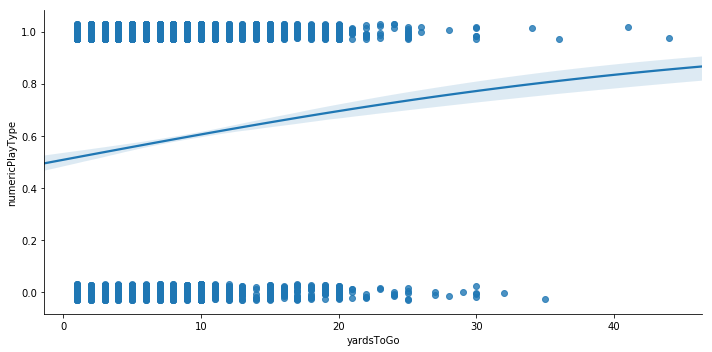

In [20]:
sns.lmplot(x="yardsToGo", y="numericPlayType", data=df.sample(frac=0.1), y_jitter=.03, 
           logistic=True, aspect=2);

This chart is providing a basic regression that says the larger the yards to go, the larger the numeric play type will be. Since a numeric play type of 1 references a pass, this means that there's a trend with more yards to go meaning more likely a passing play.

Note that the shaded area is a confidence interval of the data.

A few notes on the code:
- df.sample represents taking a random sample of the data. This is valuable for us because trying to chart all of the data is pretty slow for the roughly 100,000 plays. By taking a random sample of 10% of the data, we can still get a reasonably close understanding of the data without waiting for the chart to render. Note that each run will be a unique data set, but the chart will always be very consistent. Feel free to re-run the charting function yourself and see this in action.
- The logisitic param is forcing the regression to fit a logistic curve instead of linear. For binary problems (problems where the final value is 0 or 1) this is more appropriate
- y_jitter is useful to help the logistic fitting process. It's effectively creating noise off the y-axis values. Since all our values are either 0 or 1, a little noise cleans things up from a regression perspective

With this chart in place, let's apply it to a few more columns to see what we find.


#### Personnel Counts

With all the columns for different rostered positions, are there any trends to look at there? For simplicity, we're only going to look at offensive positions for now.

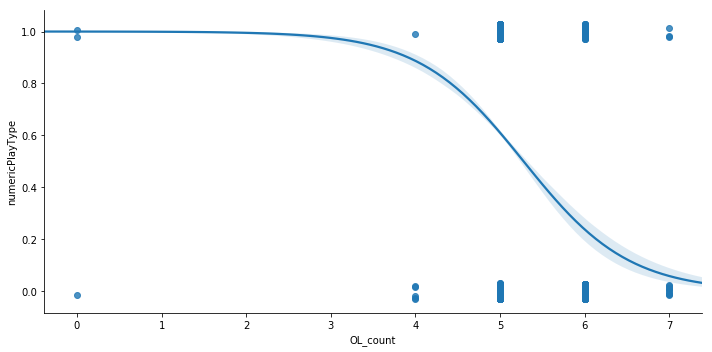

In [21]:
sns.lmplot(x='OL_count', y='numericPlayType', logistic=True, data=df.sample(frac=0.1), y_jitter=.03, aspect=2)
plt.show()

For OL, there's a pretty clear trend - the more OL are on the field, the more likely the play is a rush. Also, the regression's confidence interval shows that there is very little variance. 

Let's look at other positions as well.

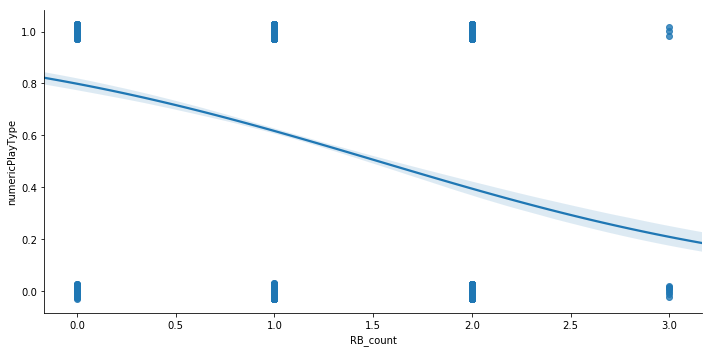

In [22]:
sns.lmplot(x='RB_count', y='numericPlayType', logistic=True, data=df.sample(frac=0.1), y_jitter=.03, aspect=2)
plt.show()

Although not as drastic as OL, RB's clearly have a trend as well. The more RB's that are on the field, the more likely the play will be a run. Intuitively, this makes sense as well. What about WR's?

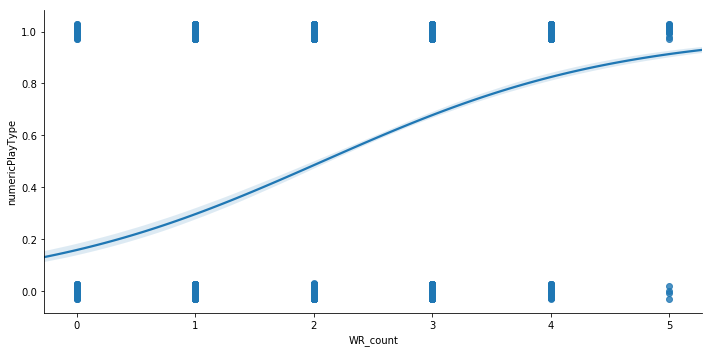

In [23]:
sns.lmplot(x='WR_count', y='numericPlayType', logistic=True, data=df.sample(frac=0.1), y_jitter=.03, aspect=2)
plt.show()

This has a bit of a reverse effect from previous graphs, but is still important - the more WR's there are on the field, the more likely the play will be a pass. Once again, this makes a lot of sense.

Unsurprisingly, the personnel on the field has a direct effect to the type of play. This means it's a good feature to use.

Overall, all of the data has a reasonable effect on guiding whether the coming play will be a pass or a rush. Let's see if a model can pick up on some of these nuances.

## Model Training

The algorithm we're going to use is [XGBoost](https://xgboost.readthedocs.io/en/latest/index.html). This algorithm relies on building boosted decision trees for each iteration of training, then ensembling them together to produce a model. The methodology has a lot of success in the ML world, being the [algorithm of choice](https://github.com/dmlc/xgboost/tree/master/demo#machine-learning-challenge-winning-solutions) for winning solutions to ML problems. In addition, there are bindings for Python, R, JVM languages, and more. All in all, it's a surprisingly flexible and strong solution for many ML problems.

Most of the following code is very specific to XGBoost, but the concepts are universal to most ML problems.

#### Set Up Final Dataset(s)

XGBoost requires data to be in numeric form, so we need to make sure all data is numeric.

In [24]:
df.head()

,playType,down,scoreDifferential,yardsToGo,DB_count,DL_count,K_count,LB_count,LS_count,OL_count,P_count,QB_count,RB_count,TE_count,WR_count,yardsToEndzone,secondsLeftInHalf,half,numericPlayType
0,play_type_rush,1,0.0,10,0,0,0,0,0,5,0,1,1,1,3,75,1796,1,0
1,play_type_rush,1,0.0,10,0,0,0,0,0,5,0,1,1,1,3,72,1791,1,0
2,play_type_rush,1,0.0,10,0,0,0,0,0,5,0,1,1,1,3,85,1795,1,0
3,play_type_rush,1,0.0,10,0,0,0,0,0,5,0,1,1,1,3,75,1800,1,0
4,play_type_pass,2,0.0,7,0,0,0,0,0,5,0,1,1,1,3,72,1767,1,1


Looks like the only column that's not numeric is `playType` - This is good because we already have `numericPlayType` available to us. Let's remove the `playType` column.

In [25]:
df = drop_columns(df, 'playType')

An important aspect of ML is splitting your data into a training set, a validation set, and a test set. This is important because it provides a basic framework to preventing overfitting. Overfitting is when a model is trained to a specific set of data to a point that it's no longer predictive, but rather explains the specific data.

Here's a quick breakdown of the different data sets:

- The training set is what the model actually trains against
- Within XGBoost, you pass in a validation set which the algorithm uses to gauge performance, which reduces the concern of overfitting. 
- The test set is reserved for after your model is built, and you want to evaluate the performance of the model against data that it's never seen before

To build these, we can just randomly select fractions of the full dataset. In our case, we're going to take the following split: 70% of the data goes to training, 20% of the data goes to validation, 10% goes for our testing purposes.

In [26]:
train_df, validation_df, test_df = np.split(df.sample(frac=1), [int(0.7 * len(df)), int(0.9 * len(df))])

print("Training size is %d, validation size is %d, test size is %d" % (len(train_df), 
                                                                           len(validation_df), 
                                                                           len(test_df)))

Training size is 69710, validation size is 19918, test size is 9959


Now we have our 3 data sets ready to go - let's start training.

#### Model Training

XGBoost uses their own data format (DMatrix), and we build it with a specific function. Let's build our DMatrix's for training and validation sets.

In [27]:
train_clean_df = drop_columns(train_df, 'numericPlayType')
d_train = xgb.DMatrix(train_clean_df, label=train_df['numericPlayType'],
                      feature_names=list(train_clean_df))

val_clean_df = drop_columns(validation_df, 'numericPlayType')
d_val = xgb.DMatrix(val_clean_df, label=validation_df['numericPlayType'],
                    feature_names=list(val_clean_df))

/opt/conda/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


The packaged version of XGBoost has a warning about Series.base - you can ignore this.

In this code, we basically created our dataset for XGBoost - we specified what our label was (`numericPlayType`) and fed the data without that column as our feature set.

Now it's time to train a model. There's a lot going on in the code below, so let's take a quick look:

- The objective of this problem is to solve a binary problem - is the following play a pass or not. Per the XGBoost documentation, the objective to use in this case is 'binary:logistic'. There are many different objectives you can pick depending on your problem.
- The eval_metric we're going to use is AUC. This is the [area under the curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic#Area_under_the_curve) - lately this has been the evaluation metric of choice for binary problems in the ML space.
- We're going to configure an early stopping round, which means that if the model's training stops improving its evaluation metric after 8 rounds of training, mark the training as finished. This is important for preventing overfitting.

The other params are called hyperparameters, all of which are documented [here](https://xgboost.readthedocs.io/en/latest/parameter.html). A deeper breakdown is available [here](https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/) as well.

It's worth playing around with different values to see what works best. If you feel comfortable, there are ways to use [AWS Sagemaker](https://aws.amazon.com/sagemaker/) for hyperparameter tuning. Unfortunately that is beyond the scope of this workshop. Another thing to note is that hyperparameter tuning can only get you so far, you'll see exponentially larger improvements with proper feature engineering and data engineering.

In [28]:
eval_list = [(d_train, 'train'), (d_val, 'eval')]
results = {}

param = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'max_depth': 5,
    'eta': 0.2,
    'rate_drop': 0.2,
    'min_child_weight': 6,
    'gamma': 4,
    'subsample': 0.8,
    'alpha': 0.1
}

num_round = 250
xgb_model = xgb.train(param, d_train, num_round, eval_list, early_stopping_rounds=8, evals_result=results)

[0]	train-auc:0.736784	eval-auc:0.735606
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 8 rounds.
[1]	train-auc:0.749912	eval-auc:0.747984
[2]	train-auc:0.751884	eval-auc:0.749404
[3]	train-auc:0.755387	eval-auc:0.752965
[4]	train-auc:0.760612	eval-auc:0.759087
[5]	train-auc:0.761872	eval-auc:0.759938
[6]	train-auc:0.765816	eval-auc:0.763928
[7]	train-auc:0.767222	eval-auc:0.765698
[8]	train-auc:0.76925	eval-auc:0.767831
[9]	train-auc:0.770534	eval-auc:0.768784
[10]	train-auc:0.771221	eval-auc:0.769531
[11]	train-auc:0.773372	eval-auc:0.772064
[12]	train-auc:0.774064	eval-auc:0.772373
[13]	train-auc:0.775148	eval-auc:0.773425
[14]	train-auc:0.776087	eval-auc:0.774369
[15]	train-auc:0.776781	eval-auc:0.77506
[16]	train-auc:0.777111	eval-auc:0.775397
[17]	train-auc:0.777564	eval-auc:0.775797
[18]	train-auc:0.778285	eval-auc:0.776163
[19]	train-auc:0.778544	eval-auc:0.776435
[20]	train-auc:0.779155	eval-auc

We now have a model. Let's take a quick look at how the training performance fared and see how the AUC changed over time.

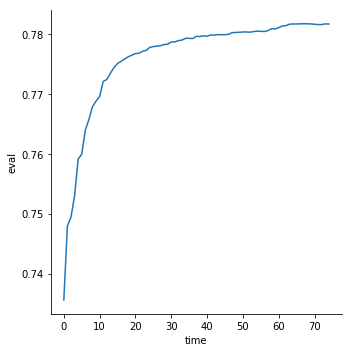

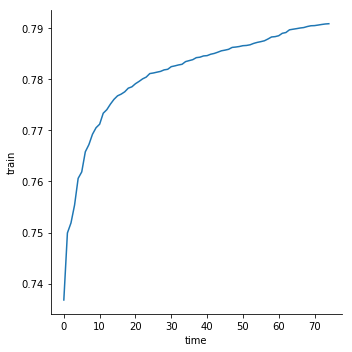

In [29]:
val_error = results.get('eval', {}).get('auc', [])
train_error = results.get('train', {}).get('auc', [])

model_perf_df = pd.DataFrame({'time': range(len(val_error)),
                              'eval': val_error, 
                              'train': train_error})

sns.relplot(x='time', y='eval', kind='line', data=model_perf_df)
sns.relplot(x='time', y='train', kind='line', data=model_perf_df)

As we can see, there was a LOT of improvement early on, but eventually the model's training plateaued. Interesting to note that the training continued to get better and better. This is to be expected - XGBoost will always try to maximize the evaluation metric for the training data. If we didn't have the early stopping round and continued to let the model train longer, we would have seen the validation dataset start decreasing it's AUC, which means the model is overfitting.

Let's determine the performance of the model with our test data now.

#### Test Data Evaluation

The first step to evaluating the test data is to actually run inference against the dataset.

In [30]:
test_clean_df = drop_columns(test_df, 'numericPlayType')
d_test = xgb.DMatrix(test_clean_df, label=test_df['numericPlayType'], 
                     feature_names=list(test_clean_df))

actual = test_df['numericPlayType']
predictions = xgb_model.predict(d_test)
print(len(test_df))

9959


In [31]:
print(predictions[:5])

[0.7065891  0.8931368  0.22953248 0.07336365 0.44490385]


We ran a similar function from above to create a DMatrix for our test dataset, then called `xgb_model.predict` - the return value is an array of predictions. 

Based on the print method above, you can see a sample of what the predictions look like. Note that these are not 0's or 1's, but rather some value in between. This effectively represents the probability that the model think's an individual record is a 1. If we wanted to determine whether the play is going to be a rush (0) or a pass (1) we would simply round the predictions, as seen below.

In [32]:
rounded_predictions = np.round(predictions)

Now let's run some metric evaluations. There are 3 main ones we're going to use today: 

- Accuracy score
- [F1 score](https://en.wikipedia.org/wiki/F1_score)
- [Brier score](https://en.wikipedia.org/wiki/Brier_score)

The accuracy score is very simple - it's simply how often the model predicted correctly.

The F1 score is a little more complex, and is factoring in false positives a little bit differently from the accuracy score. Effectively, the F1 score is looking at the number of correct positives over all positives found by the model compared to the correct positives over all the samples. The link above goes into more detail.

The Brier score weights the actual probability value on top of the correctness of the data. The link above has a good example on how it works in practice. In short, if the model predicts something with a high probability and it's correct, that's more valuable than if the model predicts the correct outcome but with very low probability. 

For reminder's sake, we have the following variables for use:
- `predictions` represents the probabilities in our `test_df`
- `rounded_predictions` represents the final 0 or 1 prediction
- `actual` represents what actually happened

In [33]:
accuracy = metrics.accuracy_score(actual, rounded_predictions)
f1 = metrics.f1_score(actual, rounded_predictions)
brier_score = metrics.brier_score_loss(actual, predictions)

print("Metrics:\nAccuracy: %.4f \nF1: %.4f \nBrier: %.4f" % (accuracy, f1, brier_score))

Metrics:
Accuracy: 0.7074 
F1: 0.7540 
Brier: 0.1840


We used [scikit-learn's metrics](https://scikit-learn.org/stable/modules/model_evaluation.html) package to help us with the actual metrics calculations. They've already written most of the evaluation metrics we'll need in practice, so best to use their functions as opposed to rewriting it ourselves.

As you can see, our raw accuracy is roughly 70%, which isn't bad for a first pass at training. The other metrics seem to be reasonable as well. These scores become more interesting as we iterate against the dataset and model params and try running things again to see if we're improving the model or not.

Let's try looking at a confusion matrix to see more of the final results.

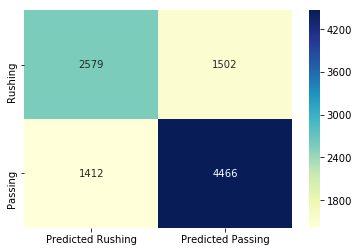

In [34]:
confusion_matrix = metrics.confusion_matrix(actual, rounded_predictions)
confusion_matrix_df = pd.DataFrame(confusion_matrix, index=["Rushing", "Passing"], 
                                   columns=["Predicted Rushing", "Predicted Passing"])
sns.heatmap(confusion_matrix_df, annot=True, fmt="d", cmap="YlGnBu")
plt.show()

The confusion matrix is a quick and easy visualization to highlight predictions vs. actual. In our case, out of the roughly 10,000 plays, about 6,000 were actual pass plays - about 4,400 of which were predicted to be passing plays. Likewise, there were about 4,000 rushing plays, about 2,600 of which were predicted to be rushing plays. 


## Next Steps

Typically, you'd take the metrics you have along with sample records and look at whether you agree with what the model learned. If you find a situation that the model tends to predict incorrectly, the next step would be to look at if there's a data point that can help explain those specific situations.

One clear cut example here is QB scrambles. These tend to be designed passing plays, but are marked as rushing plays because there was no pass thrown. We could presumably increase our accuracy by re-classifying those kind of plays.

Another example could be tracking data. Let's say that not only do we know which rostered positions are on the field, but also where they lined up on the field, the model might be able to learn basic formations and say 2 RB's in the backfield is different that 2 RB's lined up as receivers. 

Implementing one of these would involved updating the initial data set, revisiting some of the data analysis to make sure the data has reasonable influence, then running the training steps again, and comparing your final metrics to check for improvement. 

Because this process is very repetitive, it's extremely helpful to have a framework for being able to reproduce the model development and training lifecycle very easily and consistently. There are a few different tools out there, or you can use your own.